In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

In [2]:
def get_features():
    features = ['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
               'VEHCOUNT', 'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
               'SPEEDING', 'HITPARKEDCAR']
    return features

In [3]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_0cc44565e5094f17a8a43faae16694a6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='licp6sJtcDUty6NcRkTDc3iyLl75yB4sLWSOgzi0ut99',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_0cc44565e5094f17a8a43faae16694a6.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-xc9j6xbsxeqgqb',Key='Data-Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

features = get_features()
df_collision = pd.read_csv(body)[features]
df_collision.head()


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,HITPARKEDCAR
0,2,Intersection,Angles,2,0,0,2,At Intersection (intersection related),NaN,N,Overcast,Wet,Daylight,NaN,N
1,1,Block,Sideswipe,2,0,0,2,Mid-Block (not related to intersection),NaN,0,Raining,Wet,Dark - Street Lights On,NaN,N
2,1,Block,Parked Car,4,0,0,3,Mid-Block (not related to intersection),NaN,0,Overcast,Dry,Daylight,NaN,N
3,1,Block,Other,3,0,0,3,Mid-Block (not related to intersection),NaN,N,Clear,Dry,Daylight,NaN,N
4,2,Intersection,Angles,2,0,0,2,At Intersection (intersection related),NaN,0,Raining,Wet,Daylight,NaN,N


In [4]:
def get_column_na_alt(col):
    fill_na_alt = {
        'SEVERITYCODE': 0,
        'ADDRTYPE': '',
        'INTKEY': 0,
        'COLLISIONTYPE': '',
        'PERSONCOUNT': 0,
        'PEDCOUNT': 0,
        'PEDCYLCOUNT': 0,
        'VEHCOUNT': 0,
        'JUNCTIONTYPE': '',
        'INATTENTIONIND': 'N',
        'UNDERINFL': '',
        'WEATHER': '',
        'ROADCOND': '',
        'LIGHTCOND': '',
        'SPEEDING': 'N',
        'HITPARKEDCAR': ''
    }
    return fill_na_alt[col]

In [5]:
def get_processed_dataframe(df, columns):
    column_map = {}
    features = ['ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
                'VEHCOUNT', 'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
                'SPEEDING', 'HITPARKEDCAR']
    target = 'SEVERITYCODE'
    categorical_columns = ['COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']
    one_hot_columns = ['ADDRTYPE', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'HITPARKEDCAR']
    for col in categorical_columns:
        df.fillna(get_column_na_alt(col), inplace=True)
        column_map[col] = {}
        unique_values = df[col].unique()
        for i, uv in enumerate(unique_values):
            column_map[col][uv] = i
    column_map['UNDERINFL'] = {'0': 'N',
                               '1': 'Y'}
    df.replace(column_map, inplace=True)
    for col in one_hot_columns:
        df_temp = pd.get_dummies(df[col])
        df_temp_col = df_temp.columns
        df_col_rename = {}
        for col_r in df_temp_col:
            df_col_rename[col_r] = col + '_' + col_r.upper()
        df_temp.rename(columns= df_col_rename, inplace=True)
        df = df.join(df_temp)
        if '' in df_col_rename.keys():
            df.drop([col, str(col+'_').strip()], axis=1, inplace=True)
        else:
            df.drop([col], axis=1, inplace=True)
    return df, column_map, features, target

In [6]:
df_collision, column_map, features, target = get_processed_dataframe(df_collision, features)
df_collision.head()

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,ADDRTYPE_ALLEY,ADDRTYPE_BLOCK,ADDRTYPE_INTERSECTION,INATTENTIONIND_Y,UNDERINFL_N,UNDERINFL_Y,SPEEDING_Y,HITPARKEDCAR_N,HITPARKEDCAR_Y
0,2,0,2,0,0,2,0,0,0,0,0,0,1,0,1,0,0,1,0
1,1,1,2,0,0,2,1,1,0,1,0,1,0,0,1,0,0,1,0
2,1,2,4,0,0,3,1,0,1,0,0,1,0,0,1,0,0,1,0
3,1,3,3,0,0,3,1,2,1,0,0,1,0,0,1,0,0,1,0
4,2,0,2,0,0,2,0,1,0,0,0,0,1,0,1,0,0,1,0


In [14]:
def get_column_correlation(df):
    correlation = df.corr()
    sbs.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns)


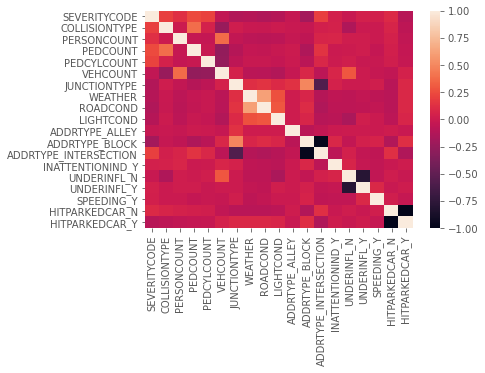

In [15]:
get_column_correlation(df_collision)

In [9]:
def apply_model(X_train, X_test, y_train, y_test, model):
    classifier = model
    classifier_model = classifier.fit(X_train, y_train)
    y_pred = classifier_model.predict(X_test)
    return get_accuracy_for_model(y_pred, y_test)


def get_accuracy_for_model(y_pred, y_test):
    return metrics.accuracy_score(y_test, y_pred)

In [10]:
def apply_model_and_get_accuracy(df):
    X = df.drop('SEVERITYCODE', axis=1)
    y = df.SEVERITYCODE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    model_list = [
        {
            'name': 'Decision Tree',
            'function': DecisionTreeClassifier(),
            'accuracy': 0
        },
        {
            'name': 'Gaussian NB',
            'function': GaussianNB(),
            'accuracy': 0
        },
        {
            'name': 'Nearest Neighbors',
            'function': NearestCentroid(),
            'accuracy': 0
        },
        {
            'name': 'Neural Network',
            'function': MLPClassifier(
                solver='lbfgs',
                alpha=1e-5,
                hidden_layer_sizes=(5, 2),
                random_state=1
            ),
            'accuracy': 0
        }
    ]
    for model in model_list:
        model['accuracy'] = apply_model(X_train, X_test, y_train, y_test, model['function'])
        print('Accuracy for ' + model['name'] + ': ', model['accuracy'])
    return model_list

In [11]:
df_collision

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,ADDRTYPE_ALLEY,ADDRTYPE_BLOCK,ADDRTYPE_INTERSECTION,INATTENTIONIND_Y,UNDERINFL_N,UNDERINFL_Y,SPEEDING_Y,HITPARKEDCAR_N,HITPARKEDCAR_Y
0,2,0,2,0,0,2,0,0,0,0,0,0,1,0,1,0,0,1,0
1,1,1,2,0,0,2,1,1,0,1,0,1,0,0,1,0,0,1,0
2,1,2,4,0,0,3,1,0,1,0,0,1,0,0,1,0,0,1,0
3,1,3,3,0,0,3,1,2,1,0,0,1,0,0,1,0,0,1,0
4,2,0,2,0,0,2,0,1,0,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,6,3,0,0,2,1,2,1,0,0,1,0,0,1,0,0,1,0
194669,1,5,2,0,0,2,1,1,0,0,0,1,0,1,1,0,0,1,0
194670,2,8,3,0,0,2,0,2,1,0,0,0,1,0,1,0,0,1,0
194671,2,4,2,0,1,1,0,2,1,5,0,0,1,0,1,0,0,1,0


In [12]:
df_collision.dtypes

SEVERITYCODE             int64
COLLISIONTYPE            int64
PERSONCOUNT              int64
PEDCOUNT                 int64
PEDCYLCOUNT              int64
VEHCOUNT                 int64
JUNCTIONTYPE             int64
WEATHER                  int64
ROADCOND                 int64
LIGHTCOND                int64
ADDRTYPE_ALLEY           uint8
ADDRTYPE_BLOCK           uint8
ADDRTYPE_INTERSECTION    uint8
INATTENTIONIND_Y         uint8
UNDERINFL_N              uint8
UNDERINFL_Y              uint8
SPEEDING_Y               uint8
HITPARKEDCAR_N           uint8
HITPARKEDCAR_Y           uint8
dtype: object

In [13]:
model_list = apply_model_and_get_accuracy(df_collision)

Accuracy for Decision Tree:  0.7471833156398754
Accuracy for Gaussian NB:  0.7047532618745933
Accuracy for Nearest Neighbors:  0.6791205780623951
Accuracy for Neural Network:  0.7035889181877333
